In [1]:
 !pip install transformers

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 5.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx


In [5]:
df=pd.read_excel('/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [6]:
pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 55.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 74.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 83.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) 

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

In [8]:
import ktrain
from ktrain import text

In [9]:
df_filtered = df[df['Label'] > 0]
df=df_filtered

In [10]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 Name: Label, dtype: int64,
 12119)

In [11]:
def Label(label):
    if(label==1):
        return 'positive'
    elif(label==2):
        return 'negative'
df['Sentiment'] = df['Label'].apply(Label)
df.Sentiment.value_counts(), len(df)

(positive    6410
 negative    5709
 Name: Sentiment, dtype: int64,
 12119)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Label'])
encoded_labels = le.transform(df['Label'])
labels = np.array(encoded_labels) # Converting into numpy array
class_names =le.classes_
print(class_names)

In [12]:
df.Sentiment.value_counts(), len(df)

(positive    6410
 negative    5709
 Name: Sentiment, dtype: int64,
 12119)

In [13]:
train=df[:int(.8*len(df))]
test=df[int(.8*len(df)):int(.9*len(df))]
validation=df[int(.9*len(df)):]
x_train=train['Token'].tolist()
y_train=train['Sentiment'].tolist()
x_validation=validation['Token'].tolist()
y_validation=validation['Sentiment'].tolist()
x_test=test['Token'].tolist()
y_test=test['Sentiment'].tolist()

In [14]:
x_train= np.array(x_train)
x_validation= np.array(x_validation)
x_test= np.array(x_test)


In [15]:
categories = ['positive','negative']

In [16]:
model_name = 'sagorsarker/bangla-bert-base'
trans = text.Transformer(model_name,maxlen=50,class_names=categories)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

In [17]:
train = trans.preprocess_train(x_train,y_train)
valid = trans.preprocess_test(x_validation,y_validation)

preprocessing train...
language: bn
train sequence lengths:
	mean : 17
	95percentile : 38
	99percentile : 48


/opt/conda/lib/python3.7/site-packages/ktrain/utils.py:625: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: bn
test sequence lengths:
	mean : 17
	95percentile : 38
	99percentile : 48


In [18]:
model = trans.get_classifier()

Downloading:   0%|          | 0.00/976M [00:00<?, ?B/s]

In [19]:
learner = ktrain.get_learner(model, train_data=train,val_data=valid, batch_size=12)

In [20]:
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
weight={i:class_weight[i] for i in range(2)}

In [21]:
learner.fit_onecycle(2e-5,10,class_weight=weight) 



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/10
808/808 [==============================] - 134s 139ms/step - loss: 0.5844 - accuracy: 0.6823 - val_loss: 0.4876 - val_accuracy: 0.7616
Epoch 2/10
808/808 [==============================] - 107s 133ms/step - loss: 0.4538 - accuracy: 0.7868 - val_loss: 0.4589 - val_accuracy: 0.7913
Epoch 3/10
808/808 [==============================] - 108s 134ms/step - loss: 0.3656 - accuracy: 0.8429 - val_loss: 0.4245 - val_accuracy: 0.8193
Epoch 4/10
808/808 [==============================] - 108s 134ms/step - loss: 0.2816 - accuracy: 0.8826 - val_loss: 0.4239 - val_accuracy: 0.8119
Epoch 5/10
808/808 [==============================] - 109s 134ms/step - loss: 0.2093 - accuracy: 0.9160 - val_loss: 0.6341 - val_accuracy: 0.7871
Epoch 6/10
808/808 [==============================] - 109s 135ms/step - loss: 0.1359 - accuracy: 0.9480 - val_loss: 0.5552 - val_accuracy: 0.8234
Epoch 7/10
808/808 [==============================] - 108s 13

In [22]:
learner.validate(class_names=categories)

              precision    recall  f1-score   support

    positive       0.83      0.82      0.83       578
    negative       0.84      0.85      0.84       634

    accuracy                           0.84      1212
   macro avg       0.84      0.84      0.84      1212
weighted avg       0.84      0.84      0.84      1212



array([[476, 102],
       [ 96, 538]])

In [23]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [24]:
y_pred = predictor.predict(x_test)
print(y_pred)

['negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'negative', 'negative', 'negative', 'positive', 'negative', 'positive', 'positive', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'negative', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'negative', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'negative', 'positive', 'positive', 'positive', 'ne

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.79      0.82       554
    positive       0.83      0.88      0.86       658

    accuracy                           0.84      1212
   macro avg       0.84      0.84      0.84      1212
weighted avg       0.84      0.84      0.84      1212



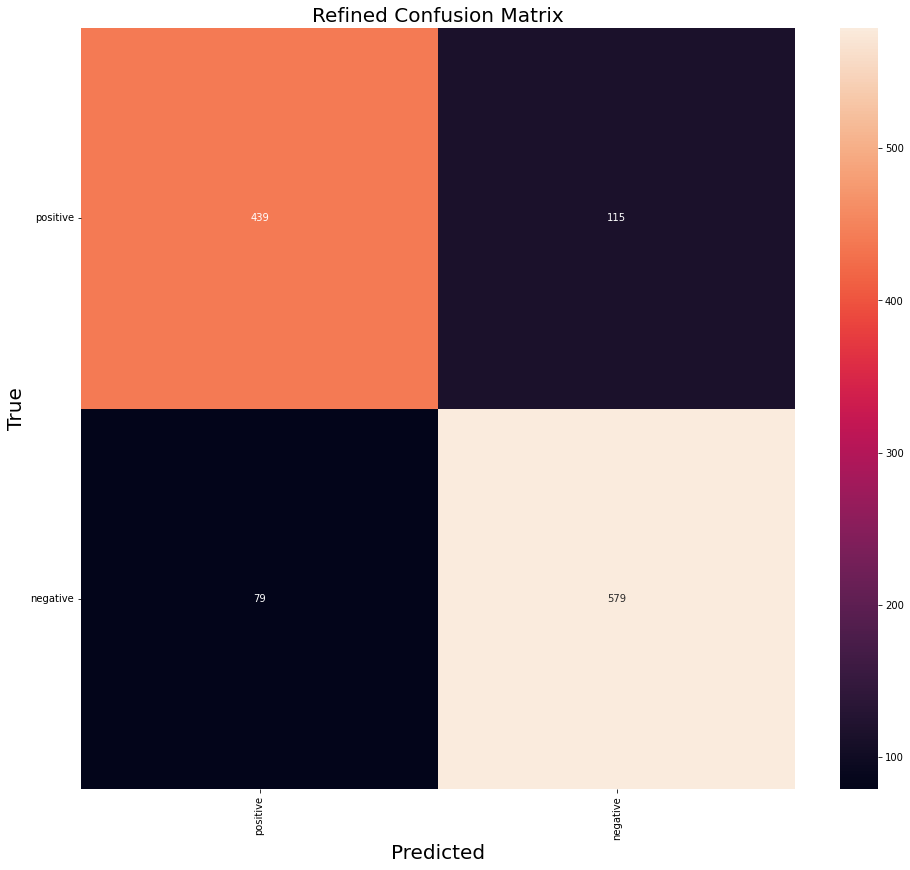

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 2
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()
